In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14-336-quickgelu', pretrained="openai", force_image_size=518)
model = model.to('cpu')
model.eval()

tokenizer = open_clip.get_tokenizer('ViT-L-14-336-quickgelu')

input_text = ['X X X bent object', 'X X X color object', 'X X X good object']

tokens = tokenizer(input_text).to('cpu')
print(tokens)




tensor([[49406,   343,   343,   343, 18369, 14115, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   343,   343,   343,  3140, 14115, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

In [4]:
device = "cpu"
import torchvision.transforms as transforms
preprocess.transforms[0] = transforms.Resize(size=(518, 518), interpolation=transforms.InterpolationMode.BICUBIC,
                                                max_size=None, antialias=None)
preprocess.transforms[1] = transforms.CenterCrop(size=(518, 518))

In [11]:
import os
from PIL import Image
dataset_root = './data/synthetic_asic/image.png'
img = Image.open(dataset_root)
img = preprocess(img)
img = img.to(device)
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 518, 518])

In [12]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from dataset import Dataset
from learnable_prompt import LearnablePrompt
from visual_prompt_tuning import VisualPromptTuning
device = "cpu"

prompt_state_all =  ['contamination']#['damage', 'scratch', 'breakage', 'burnt', 'irregular wick', 'stuck', 'crack', 'wrong place', 'partical', 'bubble', 'melded', 'hole',
                      #'melt', 'bent', 'spot', 'extra', 'chip', 'missing']

prompt_learner = LearnablePrompt(model, prompt_state=prompt_state_all, normal_token_count=5, prompt_count=10, abnormal_token_count=5, tokenizer=tokenizer, device=device)
checkpoint= torch.load('./checkpoint/vpt_lambda_4/epoch_1.pth', map_location=torch.device('cpu'))
visual_prompt = VisualPromptTuning(model=model, total_d_layer=24, num_tokens=4, device=device)
visual_prompt.load_state_dict(checkpoint["visual_prompt"])
visual_prompt.to("cpu")
prompt_learner.load_state_dict(checkpoint["prompt_learner"])
prompt_learner.to('cpu')
with torch.no_grad():
    visual_tokens = visual_prompt()
    image_features, patch_features, _ = model.encode_image([img, visual_tokens])
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    prompt, learnable_tokens, template_tokens = prompt_learner(image_features)

    text_features, learned_tokens = model.encode_learn_prompts(prompt, learnable_tokens, template_tokens)
    text_features = text_features/text_features.norm(dim=-1, keepdim=True)
    normal_text_feature = text_features[0].unsqueeze(0)
    abnormal_text_feature = text_features[1:]
    avg_abnormal_text_feature = abnormal_text_feature.mean(dim = 0, keepdim=True).unsqueeze(0)

    normal_abnormal_feature = torch.cat([normal_text_feature.expand(1, 1, -1), avg_abnormal_text_feature], dim = 1)
    text_features = torch.cat([normal_text_feature.expand(1, 1, -1), abnormal_text_feature.unsqueeze(0)], dim=1)

    probs = image_features @ text_features.permute(0, 2, 1)
    probs = (probs / 0.07).softmax(-1)




In [13]:
from adapter import LinearAdapter
trainable_adapter = LinearAdapter(dim_in=1024, dim_out=768, k=4)
trainable_adapter.load_state_dict(checkpoint["linear_adapter"])
trainable_adapter.to(device)

patch_features = trainable_adapter(patch_features)

In [14]:
print(normal_abnormal_feature, text_features.shape)
print(probs)


tensor([[[ 0.0411, -0.0320,  0.0291,  ..., -0.0347,  0.0171, -0.0443],
         [-0.0614, -0.0496, -0.0360,  ..., -0.0095, -0.0051,  0.0411]]]) torch.Size([1, 2, 768])
tensor([[[0.0091, 0.9909]]])


In [15]:
from train import compute_similarity, compute_similarity_map



anomaly_map_list= []

for idx, patch in enumerate(patch_features):
    patch = patch/patch.norm(dim = -1, keepdim=True)
    similarity = compute_similarity(patch, text_features[0])
    print(similarity.shape)
    similarity_map = compute_similarity_map(similarity, 518)
    print(similarity_map.shape)
    anomaly_map = (torch.sum(similarity_map[..., 1:], dim=-1) + (1 - similarity_map[..., 0])) / 2.0
    anomaly_map_list.append(anomaly_map)

    final_anomaly_map = torch.stack(anomaly_map_list)
    final_anomaly_map = final_anomaly_map.sum(dim = 0)
    print(final_anomaly_map.shape)
    print(final_anomaly_map)

torch.Size([1, 1369, 2])
torch.Size([1, 518, 518, 2])


torch.Size([1, 518, 518])
tensor([[[-5.0409, -5.1447, -5.2484,  ..., -7.3094, -7.2976, -7.2858],
         [-5.1135, -5.2152, -5.3169,  ..., -7.3146, -7.3025, -7.2903],
         [-5.1860, -5.2857, -5.3853,  ..., -7.3199, -7.3073, -7.2947],
         ...,
         [-6.9187, -6.9476, -6.9766,  ..., -7.6705, -7.6636, -7.6567],
         [-6.9654, -6.9927, -7.0199,  ..., -7.6851, -7.6775, -7.6699],
         [-7.0121, -7.0377, -7.0633,  ..., -7.6996, -7.6913, -7.6830]]],
       grad_fn=<SumBackward1>)
torch.Size([1, 1369, 2])
torch.Size([1, 518, 518, 2])
torch.Size([1, 518, 518])
tensor([[[-13.2649, -13.3548, -13.4447,  ..., -15.6154, -15.5940, -15.5726],
         [-13.3384, -13.4273, -13.5163,  ..., -15.6218, -15.6000, -15.5782],
         [-13.4118, -13.4998, -13.5878,  ..., -15.6283, -15.6060, -15.5838],
         ...,
         [-15.2629, -15.2851, -15.3073,  ..., -16.1270, -16.1284, -16.1298],
         [-15.3162, -15.3359, -15.3556,  ..., -16.1323, -16.1339, -16.1354],
         [-15.3694, -1

Anomaly


TypeError: Image data of dtype object cannot be converted to float

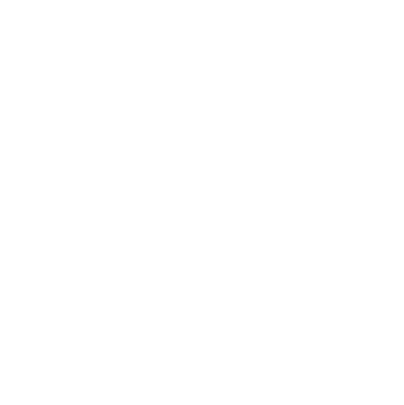

In [16]:
from visualization import visualizer
import matplotlib.pyplot as plt

b = './data/visa/pipe_fryum/Data/Images/Anomaly/11234993-24FH0022_ir_50x.png'.split('/')[-2]
print(b)

a = visualizer(['./data/synthetic_asic/image.png'], final_anomaly_map.detach().numpy(), 518, './results/', 'grouped' )
plt.figure(figsize = (5,5))
plt.axis("off")
plt.imshow(a)
plt.show()


In [7]:
similarity = 100 * probs
print(similarity)

tensor([[[9.2054e-02, 7.6434e-03, 7.6434e-03, 7.6434e-03, 7.6434e-03,
          7.6434e-03, 7.6434e-03, 7.6434e-03, 7.6434e-03, 4.4383e+00,
          7.6434e-03, 7.6434e-03, 7.6434e-03, 7.6434e-03, 7.6434e-03,
          7.6434e-03, 7.6434e-03, 7.6434e-03, 7.6434e-03, 9.5332e+01,
          7.6434e-03]]])


In [2]:
! nvidia-smi

Tue Apr 15 14:16:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40                     On  |   00000000:82:00.0 Off |                    0 |
| N/A   37C    P8             35W /  300W |     184MiB /  46068MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

torch.Size([1, 21, 768])
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


/home/nan1rng/.conda/envs/adaware/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nan1rng/.conda/envs/adaware/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


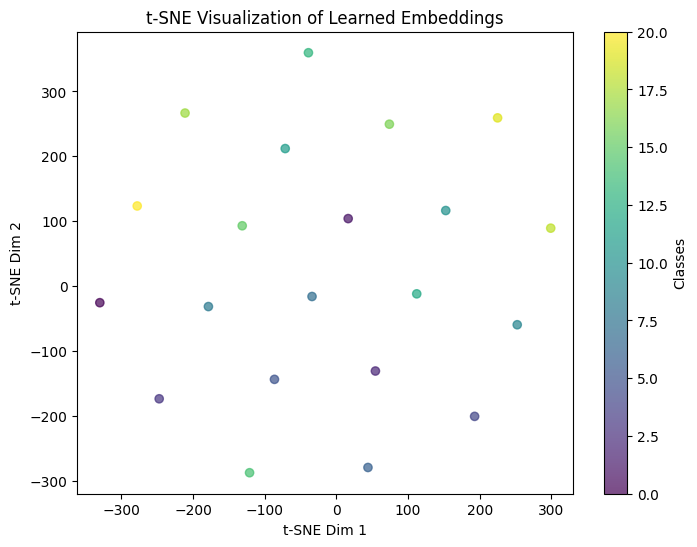

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assume `embeddings` is your learned embedding tensor (shape: [N, D])
print(text_features.shape)
embeddings = text_features.squeeze(dim=0).detach().cpu().numpy()  # Convert from tensor to NumPy
labels = [i for i in range(21)]  # List of class labels or categories for coloring
print(labels)
# Reduce dimensions to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(label="Classes")
plt.title("t-SNE Visualization of Learned Embeddings")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()


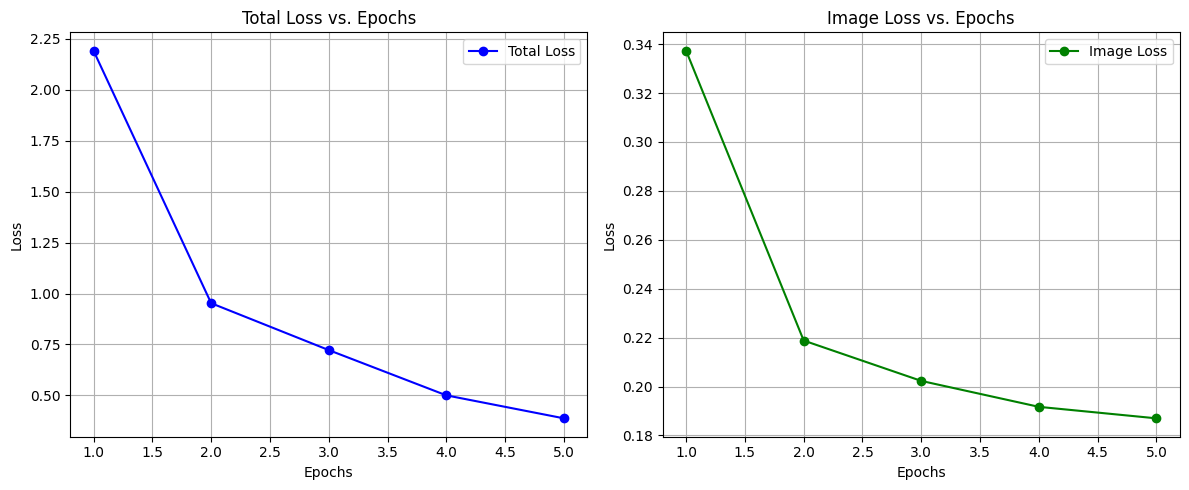

In [1]:
import matplotlib.pyplot as plt

# Loss values from training
epochs = [1, 2, 3, 4, 5]
total_loss = [2.1912, 0.9525, 0.7224, 0.5003, 0.3875]
image_loss = [0.3373, 0.2188, 0.2023, 0.1917, 0.1870]

# Plotting Total Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, total_loss, marker='o', linestyle='-', color='blue', label='Total Loss')
plt.title('Total Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plotting Image Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, image_loss, marker='o', linestyle='-', color='green', label='Image Loss')
plt.title('Image Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

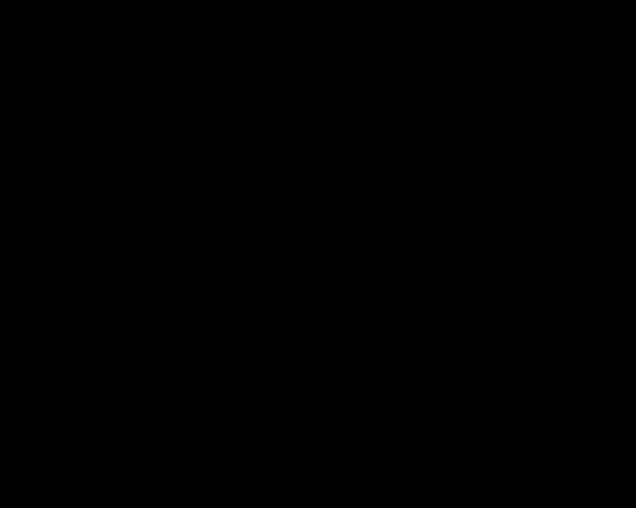

In [2]:
from PIL import Image, ImageDraw

mask = Image.new('L', (636, 508), 0)
mask

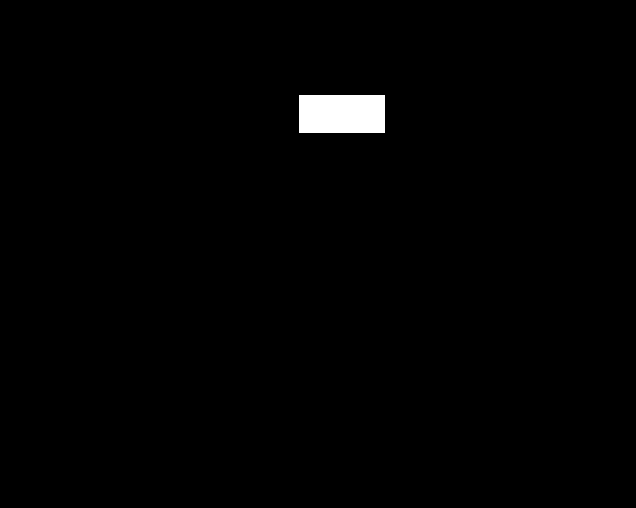

In [11]:
import numpy as np

draw = ImageDraw.Draw(mask)
draw.rectangle([299, 95,  299+85, 95+37], fill=255)
#mask = np.array(mask)
#mask = Image.fromarray(mask.astype(np.uint8), mode='L')
mask

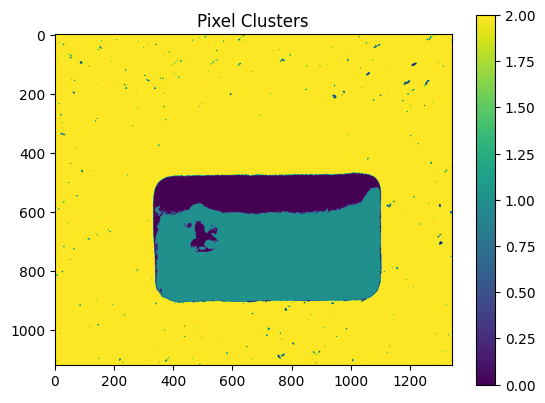

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image

# Load image
image_path = './data/visa/chewinggum/Data/Images/Anomaly/000.JPG'
img = Image.open(image_path)
img_array = np.array(img)

# Reshape to 2D array of pixels (H*W, C)
h, w, c = img_array.shape
pixels = img_array.reshape((h * w, c))

# Cluster pixels (e.g., 5 clusters)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(pixels)

# Reshape back to image dimensions
clustered_img = cluster_labels.reshape(h, w)

# Display clustered image
plt.imshow(clustered_img, cmap='viridis')
plt.colorbar()
plt.title('Pixel Clusters')
plt.show()

In [28]:
dataset_root = './data/visa/chewinggum/Data/Images/Anomaly/000.JPG'
img = Image.open(dataset_root)
img_array = np.array(img)
print(img_array.shape)
h, w = img_array.shape[1,2]
patch_size = 16  # CLIP ViT-B/32 uses 32x32 patches
grid_h = h // patch_size
grid_w = w // patch_size
print(grid_h, grid_w)
plt.imshow(img)
for i, (txt, prob) in enumerate(zip(text_features, probs)):
    # Find most relevant image region
    print(prob)
    heatmap = prob.reshape(grid_h, grid_w)  # approximate patch size
    heatmap = np.kron(heatmap, np.ones((patch_size, patch_size  )))  # upsample
    
    plt.imshow(heatmap, alpha=0.5, cmap='jet')
    plt.text(10, 30*i + 10, txt, color='white', backgroundcolor='black')
plt.title('Text Query Attention Regions')
plt.show()

(1118, 1342, 3)


TypeError: tuple indices must be integers or slices, not tuple

In [48]:
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image

img = Image.open('./data/visa/chewinggum/Data/Images/Anomaly/000.JPG')
img_array = np.array(img)
h, w, _ = img_array.shape

# Reshape to pixels and add XY coordinates for spatial coherence
pixels = img_array.reshape(-1, 3)
xx, yy = np.meshgrid(np.arange(w), np.arange(h))
coords = np.column_stack([yy.ravel(), xx.ravel()])  # (H*W, 2)

# Combine color + spatial features (weight spatial less)
features = np.hstack([pixels, coords * 0.5])  # [R,G,B,Y,X]

# Cluster (e.g., 15 clusters for fine details)
kmeans = KMeans(n_clusters=21, random_state=42)
cluster_labels = kmeans.fit_predict(features)
clustered_img = cluster_labels.reshape(h, w)

In [49]:
cluster_descriptions = []
prompt_state_all = ["good", "damage", "scratch", "breakage", "burnt", "weird_wick", "stuck", "partical", "crack", "wrong_place", "bubble", "melded",
                        "hole", "melt", "bent", "spot", "extra", "missing", "chip", "discolor", "leak"]
for cluster_id in range(kmeans.n_clusters):
    cluster_mask = (cluster_labels == cluster_id)
    

    cluster_probs = probs.squeeze()
    top3_idx = torch.topk(cluster_probs, k=3).indices
    top3_idx = top3_idx.numpy()
    print(top3_idx)
    print(text_features.shape)
    #top3_idx = np.argsort(cluster_probs)[-3:][::-1]
    top3_texts = [(prompt_state_all[i]) for i in top3_idx]
    top3_scores = [f"{cluster_probs[i]:.2f}" for i in top3_idx]
    
    cluster_descriptions.append((top3_texts, top3_scores))

[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])
[0 7 2]
torch.Size([1, 21, 768])


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

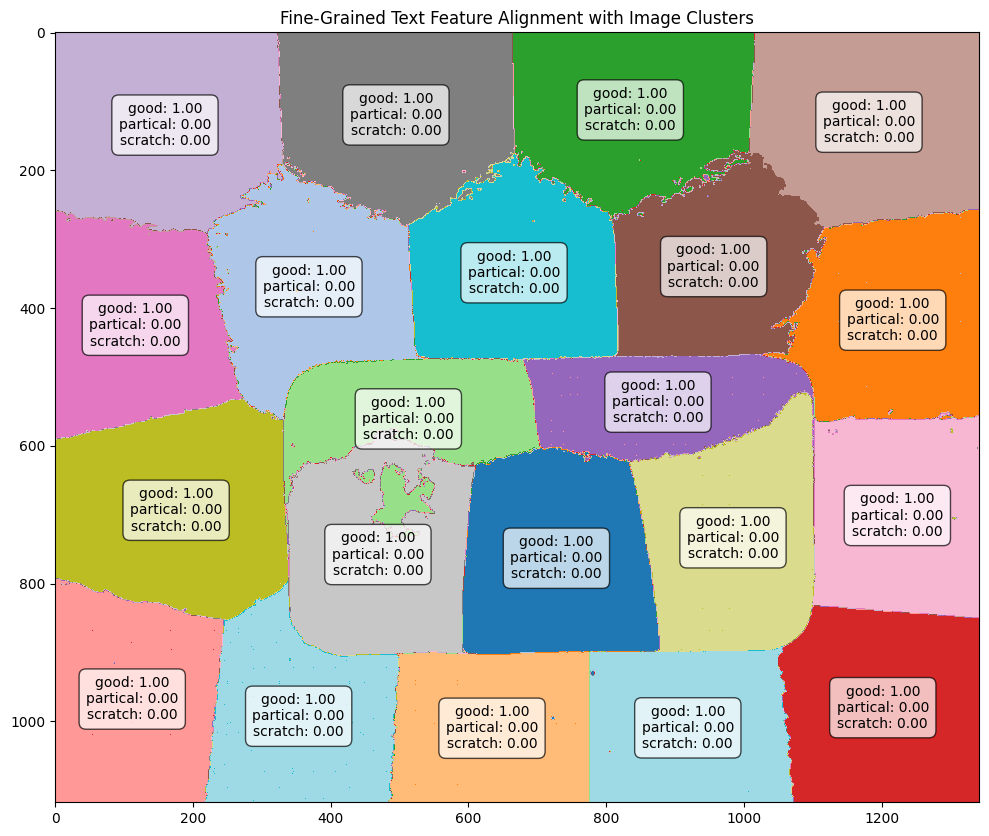

In [50]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(clustered_img, cmap="tab20")  # High-contrast colormap

# Label each cluster with its top text features
for cluster_id in range(kmeans.n_clusters):
    # Find cluster centroid
    y, x = np.mean(np.where(clustered_img == cluster_id), axis=1)
    texts, scores = cluster_descriptions[cluster_id]
    
    # Create annotation
    label = "\n".join([f"{t}: {s}" for t, s in zip(texts, scores)])
    
    ax.text(x, y, label, 
            ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.7, boxstyle="round,pad=0.5"))

plt.title("Fine-Grained Text Feature Alignment with Image Clusters")
plt.colorbar(label="Cluster ID")
plt.show()

In [1]:
import torch
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms("ViT-L-14-336-quickgelu", "openai")
preprocess

/home/nan1rng/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Extension horovod.torch has not been built: /home/nan1rng/.conda/envs/adaware/lib/python3.9/site-packages/horovod/torch/mpi_lib_v2.cpython-39-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still available.


Compose(
    Resize(size=336, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(336, 336))
    <function _convert_to_rgb at 0x7f356d6a70d0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [10]:
from torchvision import transforms
import copy
new_transform = list(copy.copy(preprocess.transforms))
new_transform[0] = transforms.Resize((336), transforms.InterpolationMode.BICUBIC, max_size=None, antialias=True)
new_transform[1] = transforms.CenterCrop(336)
new_preprocess = transforms.Compose(new_transform)

new_preprocess, preprocess


(Compose(
     Resize(size=336, interpolation=bicubic, max_size=None, antialias=True)
     CenterCrop(size=(336, 336))
     <function _convert_to_rgb at 0x7efd0b656160>
     ToTensor()
     Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
 ),
 Compose(
     Resize(size=336, interpolation=bicubic, max_size=None, antialias=True)
     CenterCrop(size=(336, 336))
     <function _convert_to_rgb at 0x7efd0b656160>
     ToTensor()
     Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
 ))

In [8]:
device = "cpu"
! nvidia-smi
model = model.to('cpu')
   
model.eval()
new_preprocess

Wed Jul 16 17:22:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.51.03              Driver Version: 575.51.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro P6000                   On  |   00000000:37:00.0 Off |                    0 |
| 26%   33C    P8              8W /  250W |      47MiB /  23040MiB |      0%   Prohibited |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Compose(
    Resize(size=(336, 336), interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(336, 336))
    <function _convert_to_rgb at 0x7efd0b656160>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

torch.Size([1, 3, 336, 336])

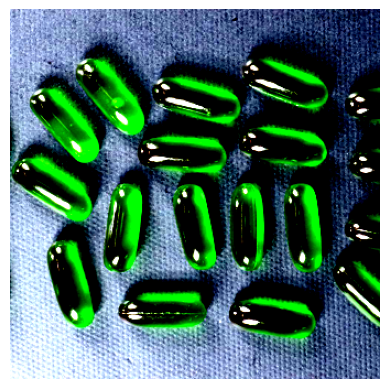

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
dataset_root = './data/visa_v2/capsules/Data/Images/Anomaly/000.JPG'
img = Image.open(dataset_root)
img = new_preprocess(img)
img = img.to(device)
img = img.unsqueeze(0)
plt.imshow(img.squeeze().permute(1,2,0))
plt.axis("off")
img.shape

In [147]:
from visual_prompt_tuning import VisualPromptTuning
checkpoint= torch.load("./checkpoint/epoch_8.pth", map_location=device)
visual_token = VisualPromptTuning(model=model, total_d_layer=24, num_tokens=4, device=device)
visual_token.load_state_dict(checkpoint["visual_prompt"])
visual_token.to(device)
visual_token.eval()
with torch.no_grad():
    vis_token = visual_token()
    img_feature, patch_tokens, attn_weight = model.encode_image([img, vis_token])



In [148]:
patch_tokens[0].shape

torch.Size([1, 577, 1024])

In [149]:
cls_attn = attn_weight[:, 0, 5:]
cls_attn.shape
h= int(cls_attn.shape[1] ** 0.5)
cls_attn_weight = cls_attn.reshape(1, 1, h, h)
cls_attn_weight= torch.nn.functional.interpolate(cls_attn_weight, 336, mode='bilinear', align_corners=True)
cls_attn_weight.shape

torch.Size([1, 1, 336, 336])

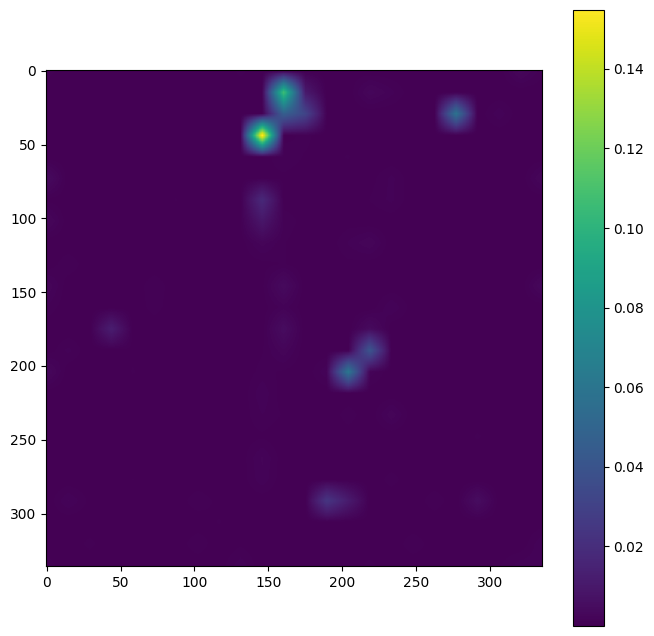

In [150]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(cls_attn_weight.squeeze().detach().cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.show()

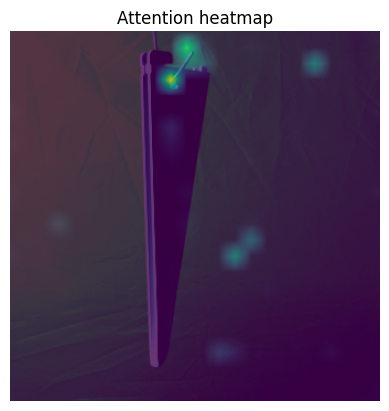

In [151]:

plt.imshow(img.squeeze().permute(1, 2, 0).detach().cpu().numpy(), cmap="hot")
plt.imshow(cls_attn_weight.squeeze().detach().cpu().numpy(), cmap="viridis", alpha=0.8)
plt.title("Attention heatmap")
plt.axis("off")
plt.show()

In [156]:
from learnable_prompt import LearnablePrompt
tokenizer = open_clip.get_tokenizer('ViT-L-14-336-quickgelu')
cls = "bracket white"
learmable_prompt = LearnablePrompt(clip_model=model, prompt_state= [f"{cls} with unintended extra hole", f"{cls} with visible spots caused by uneven paint", f"{cls} with additional bends at the edges", f"{cls} with missing screws and additional bends",
                              f"{cls} having small or large visible scratch on the surface", f"{cls} with small or full rust on metal surface", f"{cls}with flattened or squashed"], normal_token_count=5, abnormal_token_count=5, prompt_count=10, tokenizer=tokenizer, device=device)
learmable_prompt.load_state_dict(checkpoint["prompt_learner"])
learmable_prompt.to(device)
learmable_prompt.eval()
with torch.no_grad():
    prompt, learnable_tokens, template_tokens = learmable_prompt("image_features")
    text_features, learned_tokens = model.encode_learn_prompts(prompt, learnable_tokens, template_tokens)

In [157]:
text_features.shape

torch.Size([8, 768])

In [158]:

text_features_norm = text_features/text_features.norm(dim=-1, keepdim=True)
text_features_norm

tensor([[ 0.1261, -0.0032,  0.0043,  ..., -0.0119,  0.0274, -0.0222],
        [-0.0955, -0.0100,  0.0089,  ...,  0.0318, -0.0571,  0.0249],
        [-0.0935, -0.0109,  0.0006,  ...,  0.0355, -0.0659,  0.0230],
        ...,
        [-0.1002, -0.0212, -0.0021,  ...,  0.0216, -0.0615,  0.0297],
        [-0.0861, -0.0073,  0.0010,  ...,  0.0285, -0.0600,  0.0330],
        [-0.0994, -0.0182, -0.0050,  ...,  0.0404, -0.0566,  0.0275]])

In [159]:
img_feature = img_feature / img_feature.norm(dim=-1, keepdim=True)
probs = ((img_feature @ text_features_norm.T)/0.07).softmax(dim=-1)
probs

tensor([[3.6314e-05, 1.4691e-01, 1.4495e-01, 1.3944e-01, 1.3733e-01, 1.3262e-01,
         1.4299e-01, 1.5573e-01]])

In [153]:
from train import compute_similarity_map, compute_similarity
from adapter import LinearAdapter
adapter = LinearAdapter(dim_in=1024, dim_out=768, k=4)
adapter.load_state_dict(checkpoint["linear_adapter"])
adapter.eval()
print(patch_tokens[0].shape)
with torch.no_grad():
    patch_tokens = adapter(patch_tokens)




torch.Size([1, 577, 1024])


In [160]:
similarity = compute_similarity(patch_tokens[0], text_features).softmax(dim=-1)
similarity_map = compute_similarity_map(similarity, 336)
print(similarity_map.shape)
anomaly_map = torch.sum(similarity_map[:, : , : ,1:], dim=-1)
anomaly_map.shape

torch.Size([1, 336, 336, 8])


torch.Size([1, 336, 336])

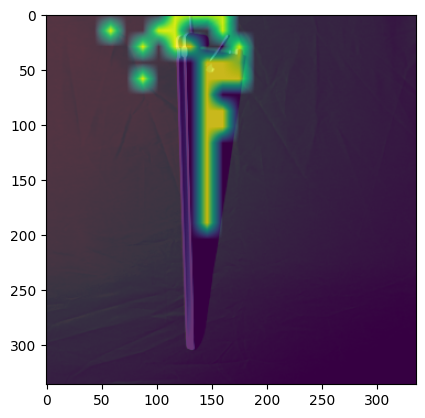

In [161]:
plt.imshow(img.squeeze().permute(1, 2, 0).detach().cpu().numpy(), cmap="hot")
plt.imshow(anomaly_map.squeeze().detach().cpu().numpy(), cmap="viridis", alpha=0.8)


In [12]:
len(a["candle"])
del sum

In [14]:
count = sum(1  for d in a["candle"] if d["anomaly"] == 1)
count

100

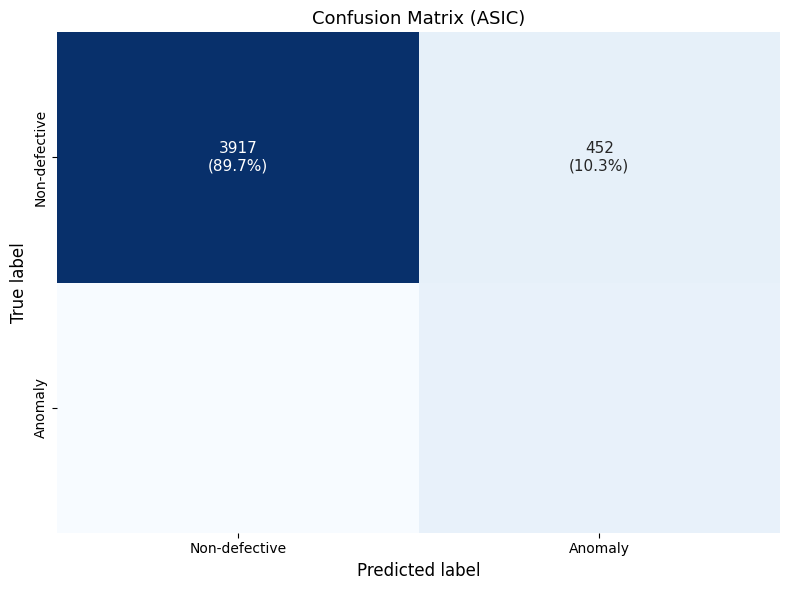

Confusion Matrix values:
True Non-defective, Predicted Non-defective: 3917 (89.7%)
True Non-defective, Predicted Anomaly: 452 (10.3%)
True Anomaly, Predicted Non-defective: 123 (22.8%)
True Anomaly, Predicted Anomaly: 417 (77.2%)


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Example data
y_true = ['Non-defective'] * 4369 + ['Anomaly'] * 540
y_pred = ['Non-defective'] * 3917 + ['Anomaly'] * 452 + ['Non-defective'] * 123 + ['Anomaly'] * 417

# Compute matrix
cm = confusion_matrix(y_true, y_pred, labels=['Non-defective', 'Anomaly'])
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

labels = np.array([[f'{val}\n({pct:.1f}%)' for val, pct in zip(row, pct_row)] 
                   for row, pct_row in zip(cm, cm_percent)])

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create heatmap
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', 
            xticklabels=['Non-defective', 'Anomaly'],
            yticklabels=['Non-defective', 'Anomaly'], 
            cbar=False, annot_kws={"fontsize": 11}, ax=ax)

# CRITICAL: Set ylim AFTER creating heatmap
ax.set_ylim(2.0, 0.0)  # Use 2.0 instead of len(cm) for clarity

# Labels and title
ax.set_xlabel('Predicted label', fontsize=12)
ax.set_ylabel('True label', fontsize=12)
ax.set_title('Confusion Matrix (ASIC)', fontsize=13)

# Adjust layout
plt.tight_layout()

# Save WITHOUT bbox_inches='tight' - this is key!
plt.savefig("confusion_matrix_cleaned.pdf", dpi=300)
plt.show()

print("Confusion Matrix values:")
print(f"True Non-defective, Predicted Non-defective: {cm[0,0]} ({cm_percent[0,0]:.1f}%)")
print(f"True Non-defective, Predicted Anomaly: {cm[0,1]} ({cm_percent[0,1]:.1f}%)")
print(f"True Anomaly, Predicted Non-defective: {cm[1,0]} ({cm_percent[1,0]:.1f}%)")
print(f"True Anomaly, Predicted Anomaly: {cm[1,1]} ({cm_percent[1,1]:.1f}%)")

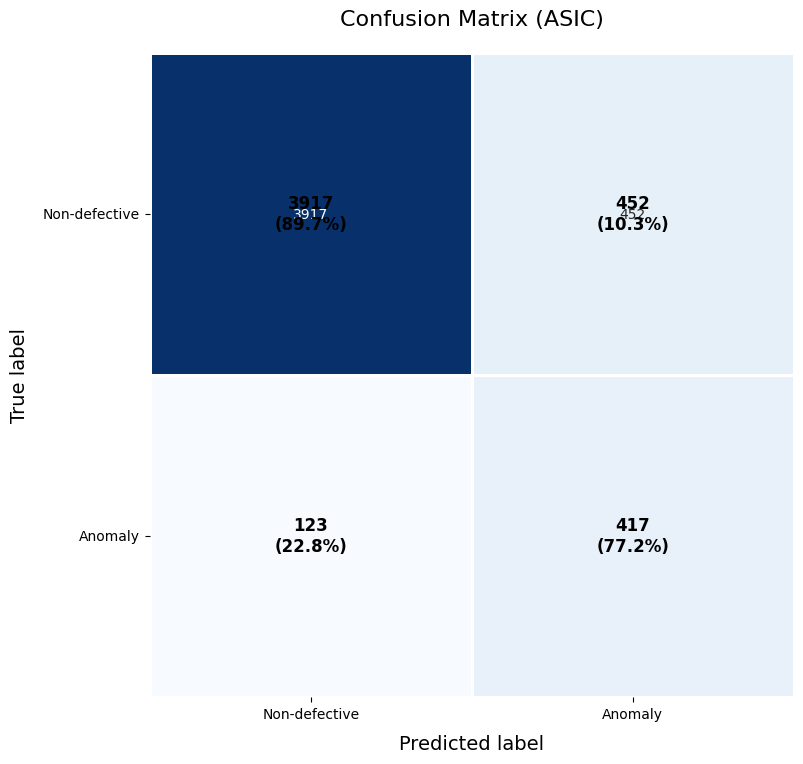

METHOD 2: Using imshow instead of heatmap


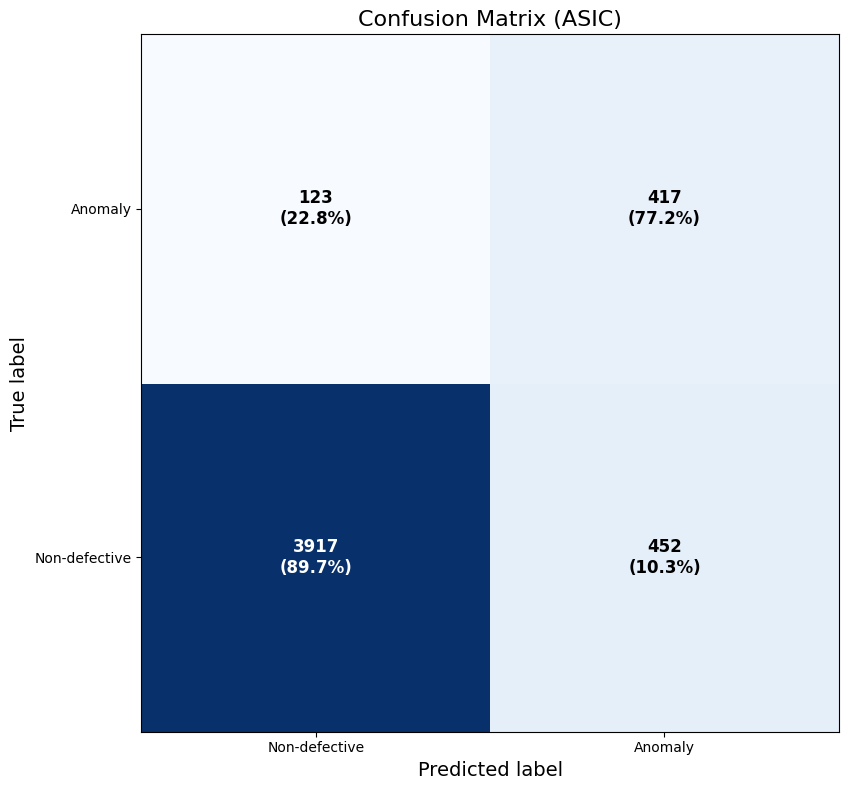

METHOD 3: Manual approach with matplotlib patches


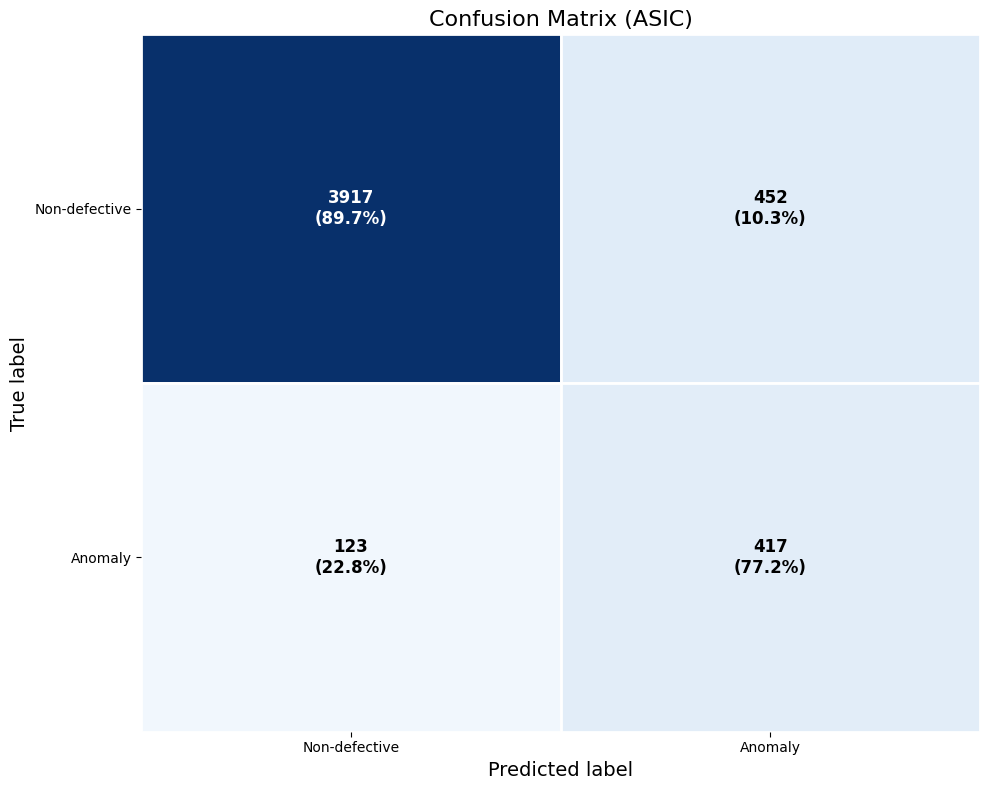


Confusion Matrix Values:
[[3917,  452]
 [ 123,  417]]

Actual data check:
Total true Non-defective: 4369
Total true Anomaly: 540
Total predicted: 4909


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Example data
y_true = ['Non-defective'] * 4369 + ['Anomaly'] * 540
y_pred = ['Non-defective'] * 3917 + ['Anomaly'] * 452 + ['Non-defective'] * 123 + ['Anomaly'] * 417

# Compute matrix
cm = confusion_matrix(y_true, y_pred, labels=['Non-defective', 'Anomaly'])
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Method 1: Force matplotlib to show everything with explicit boundaries
plt.figure(figsize=(10, 8))  # Even larger figure

# Create the heatmap with explicit square parameter
ax = sns.heatmap(cm, 
                 annot=True,  # Start with True first
                 fmt='d',     # Show integers first
                 cmap='Blues', 
                 xticklabels=['Non-defective', 'Anomaly'],
                 yticklabels=['Non-defective', 'Anomaly'], 
                 cbar=False, 
                 square=True,  # Force square cells
                 linewidths=1, linecolor='white')  # Add grid lines

# Now add custom annotations with percentages
for i in range(len(cm)):
    for j in range(len(cm[0])):
        text = f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)'
        ax.text(j+0.5, i+0.5, text, ha='center', va='center', 
                fontsize=12, fontweight='bold')

# Critical fix: Set axis limits with padding
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()  # Ensure correct orientation

plt.xlabel('Predicted label', fontsize=14, labelpad=10)
plt.ylabel('True label', fontsize=14, labelpad=10)
plt.title('Confusion Matrix (ASIC)', fontsize=16, pad=20)

# Rotate labels if needed
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout(pad=2.0)  # Extra padding
plt.savefig("confusion_matrix_method1.pdf", dpi=300, facecolor='white')
plt.show()

print("="*50)
print("METHOD 2: Using imshow instead of heatmap")
print("="*50)

# Method 2: Using imshow for more control
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap using imshow
im = ax.imshow(cm, cmap='Blues', aspect='equal')

# Add text annotations with white color only for first cell (0,0)
for i in range(len(cm)):
    for j in range(len(cm[0])):
        text = f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)'
        # White color only for the first cell (i=0, j=0), black for all others
        text_color = 'white' if (i == 0 and j == 0) else 'black'
        ax.text(j, i, text, ha='center', va='center', 
                fontsize=12, fontweight='bold', color=text_color)

# Set ticks and labels
ax.set_xticks(range(len(cm)))
ax.set_yticks(range(len(cm)))
ax.set_xticklabels(['Non-defective', 'Anomaly'])
ax.set_yticklabels(['Non-defective', 'Anomaly'])

# Set explicit limits
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix (ASIC)', fontsize=16)

plt.tight_layout()
plt.savefig("confusion_matrix_method2.pdf", dpi=300, facecolor='white')
plt.show()

print("="*50)
print("METHOD 3: Manual approach with matplotlib patches")
print("="*50)

# Method 3: Complete manual control
fig, ax = plt.subplots(figsize=(10, 8))

# Normalize values for coloring
cm_norm = cm / cm.max()

# Create colored rectangles manually
from matplotlib.patches import Rectangle
colors = plt.cm.Blues(cm_norm)

for i in range(2):
    for j in range(2):
        rect = Rectangle((j, 1-i), 1, 1, facecolor=colors[i,j], edgecolor='white', linewidth=2)
        ax.add_patch(rect)
        
        # Add text
        text = f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)'
        ax.text(j+0.5, 1-i+0.5, text, ha='center', va='center', 
                fontsize=12, fontweight='bold', 
                color='white' if cm_norm[i,j] > 0.5 else 'black')

# Set up the plot
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_xticks([0.5, 1.5])
ax.set_yticks([0.5, 1.5])
ax.set_xticklabels(['Non-defective', 'Anomaly'])
ax.set_yticklabels(['Anomaly', 'Non-defective'])  # Reversed for correct orientation

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix (ASIC)', fontsize=16)

# Remove spines
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig("confusion_matrix_method3.pdf", dpi=300, facecolor='white')
plt.show()

# Print the actual confusion matrix for verification
print("\nConfusion Matrix Values:")
print(f"[[{cm[0,0]:4d}, {cm[0,1]:4d}]")
print(f" [{cm[1,0]:4d}, {cm[1,1]:4d}]]")
print(f"\nActual data check:")
print(f"Total true Non-defective: {sum(1 for x in y_true if x == 'Non-defective')}")
print(f"Total true Anomaly: {sum(1 for x in y_true if x == 'Anomaly')}")
print(f"Total predicted: {len(y_pred)}")

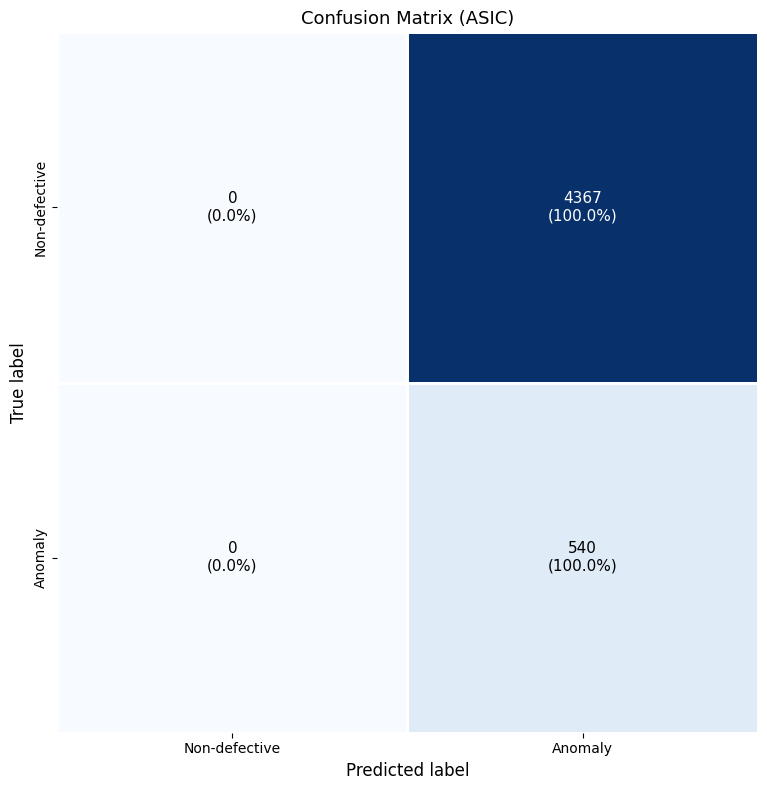

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Your data
y_true = ['Non-defective'] * 4367 + ['Anomaly'] * 540
y_pred = ['Anomaly'] * (4367 + 540) 

# Compute matrix
cm = confusion_matrix(y_true, y_pred, labels=['Non-defective', 'Anomaly'])
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# CRITICAL FIX: Use square=True and explicit axis setup
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=False, fmt='', cmap='Blues', 
                 xticklabels=['Non-defective', 'Anomaly'],
                 yticklabels=['Non-defective', 'Anomaly'], 
                 cbar=False, square=True, linewidths=1)

# Add annotations manually
for i in range(len(cm)):
    for j in range(len(cm[0])):
        text = f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)'
        text_color = 'white' if (i == 0 and j == 1) else 'black'
        ax.text(j+0.5, i+0.5, text, ha='center', va='center', fontsize=11, color=text_color)

# Force the limits
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()

plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.title('Confusion Matrix (ASIC)', fontsize=13)
plt.tight_layout()
plt.savefig("confusion_matrix_fixed.pdf", dpi=300)
plt.show()